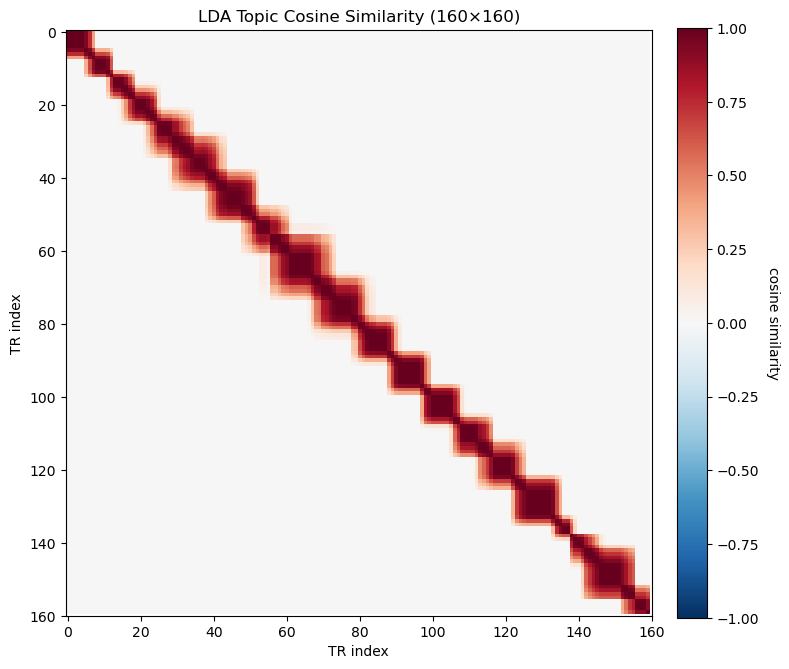

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition           import LatentDirichletAllocation
from scipy.interpolate               import interp1d

# ─── USER PARAMETERS ────────────────────────────────────────────────────────
transcript_csv = "/Volumes/Passport/fmriprep/pieman_align.csv"
TR             = 1.5                # seconds per TR
keep_slice     = slice(13, 173)     # TRs 13…172 → 160 timepoints
n_topics       = 100
window_size    = 50                 # words per sliding window
feat_dir       = os.path.join(
    "/Volumes/Passport/fmriprep/derivatives",
    "pieMan_features", "sub-002_run-1"
)
os.makedirs(feat_dir, exist_ok=True)
# ─────────────────────────────────────────────────────────────────────────────

# 1) load & clean your transcript
cols = ["word", "lemma", "onset_sec", "offset_sec"]
with open(transcript_csv) as f:
    first = f.readline().strip().split(",")
skip = 1 if first[0].lower() == "word" else 0

df = (
    pd.read_csv(transcript_csv, skiprows=skip, header=None, names=cols)
      .rename(columns=lambda s: s.strip())
      .dropna(subset=["onset_sec"])
      .reset_index(drop=True)
)

# 2) build overlapping windows of W words (slide by 1)
texts = []
times = []
N     = len(df)

for i in range(N):
    lo = max(0, i - window_size // 2)
    hi = lo + window_size
    if hi > N:
        hi = N
        lo = N - window_size if N >= window_size else 0
    window = df.iloc[lo:hi]
    texts.append(" ".join(window["word"].tolist()))
    t0 = float(window["onset_sec"].iat[0])
    t1 = float(window["offset_sec"].iat[-1]) if not pd.isna(window["offset_sec"].iat[-1]) else float(window["onset_sec"].iat[-1])
    times.append((t0 + t1) / 2)

times = np.array(times)  # seconds

# 3) vectorize texts → raw counts
vec      = CountVectorizer(stop_words="english")
X_counts = vec.fit_transform(texts)  # shape (n_windows, vocab_size)

# 4) fit LDA with the correct parameter name
lda = LatentDirichletAllocation(
    n_components    = n_topics,
    learning_method = "batch",
    random_state    = 0,
)
W_topics = lda.fit_transform(X_counts)  # (n_windows, n_topics)

# 5) convert to TR‐space and collapse any duplicate TR‐times
tr_times = times / TR  # e.g. 13.2, 13.9, ...
df_topics = pd.DataFrame(W_topics, index=tr_times)
df_mean   = df_topics.groupby(level=0).mean()  # average any rows with identical index
uniq_tr   = df_mean.index.values              # sorted, unique TR‐coordinates
mean_W    = df_mean.values                     # (n_unique, n_topics)

# 6) build your interpolator over those unique TR‐coords
f_interp = interp1d(
    uniq_tr,
    mean_W,
    axis=0,
    kind="linear",
    bounds_error=False,
    fill_value="extrapolate",
)

# 7) sample at every integer TR up to the max
n_total_TRs = int(np.ceil(uniq_tr.max())) + 1
Y = f_interp(np.arange(n_total_TRs))  # shape (n_total_TRs, n_topics)

# 8) select your analysis window
Y_sub = Y[keep_slice, :]  # → (160, n_topics)

# 9) save your topic‐proportions for later
np.save(os.path.join(feat_dir, "topics_lda.npy"), Y_sub)

# 10) compute pairwise cosine‐similarity
Yn     = Y_sub / np.linalg.norm(Y_sub, axis=1, keepdims=True)
cos_sim = Yn.dot(Yn.T)  # (160 × 160)

# 11) plot the heatmap
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(
    cos_sim,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    interpolation="nearest",
    aspect="equal",
)
ax.set_title("LDA Topic Cosine Similarity (160×160)")
ax.set_xlabel("TR index")
ax.set_ylabel("TR index")
ticks = np.arange(0, cos_sim.shape[0] + 1, 20)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("cosine similarity", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

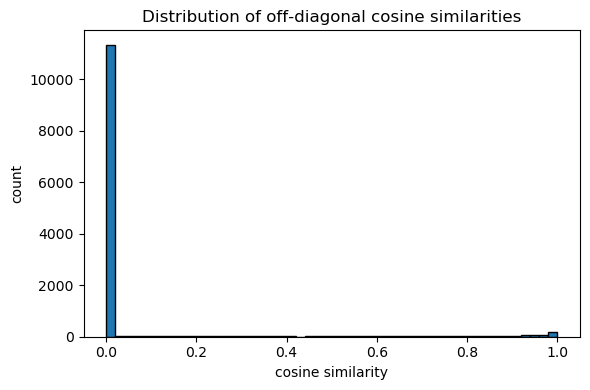

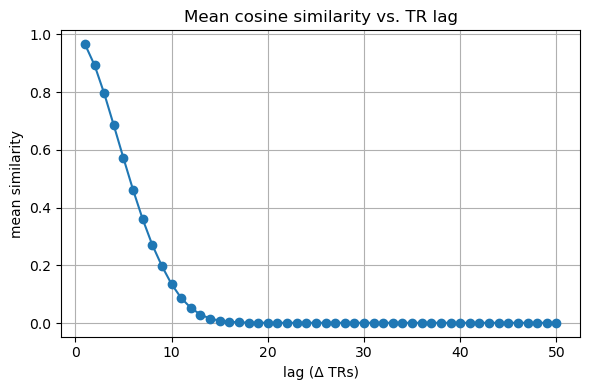

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# assume cos_sim is your (160×160) cosine‐similarity matrix

# 1) Histogram of off‐diagonal similarities
n = cos_sim.shape[0]
# grab all i<j entries
off_diag = cos_sim[np.triu_indices(n, k=1)]

plt.figure(figsize=(6,4))
plt.hist(off_diag, bins=50, edgecolor='k')
plt.title("Distribution of off‐diagonal cosine similarities")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 2) Mean similarity as a function of TR‐lag
max_lag = 50   # or up to n−1, but usually a few dozen is enough
lags = np.arange(1, max_lag+1)
mean_sim = [np.nanmean(np.diag(cos_sim, k=lag)) for lag in lags]

plt.figure(figsize=(6,4))
plt.plot(lags, mean_sim, marker='o')
plt.title("Mean cosine similarity vs. TR lag")
plt.xlabel("lag (Δ TRs)")
plt.ylabel("mean similarity")
plt.grid(True)
plt.tight_layout()
plt.show()